# Yeast Polarisome

In [1]:
import os
import sys
import math
import matplotlib.pyplot as plt
import numpy

In [2]:
sys.path.append('../..')
import spatialpy

In [3]:
class Cdc42(spatialpy.DataFunction):
    def __init__(self, a=-4 * numpy.pi, b=4 * numpy.pi, N=160):
        """ 1D domain from a to b. """
        spatialpy.DataFunction.__init__(self, name="Cdc42")
        self.a = a
        self.b = b
        self.N = N

    def expression(self):
        Gradient_max = 3.0 * 160 / self.N
        Gradient_max = Gradient_max * 0.7917
        Gradient_sigma = 20.3837
        numer = f"-1 * pow((me->x[0] * 360 / ({self.b - self.a})), 2)"
        denom = f"{2 * Gradient_sigma**2}"
        return f"100 * {Gradient_max} * exp({numer} / {denom})"

    def map(self, x):  #for vizulization
        Gradient_max = 3.0 * 160 / self.N
        Gradient_max = Gradient_max * 0.7917
        Gradient_sigma = 20.3837
        return 100 * Gradient_max * numpy.exp( 
                -1 * ((x[0] * 360 / (self.b - self.a))**2) / (2 * Gradient_sigma**2)
            )

In [4]:
class polarisome_1D(spatialpy.Model):

    def __init__(self,model_name="polarisome_1D"):
        spatialpy.Model.__init__(self,model_name)

        default_D = 0.0053
        fast_D = 1000 * default_D
        # Species
        Bni1c = spatialpy.Species(name="Bni1c",  diffusion_coefficient=fast_D)
        Bni1m = spatialpy.Species(name="Bni1m",  diffusion_coefficient=default_D)
        Spa2c = spatialpy.Species(name="Spa2c",  diffusion_coefficient=fast_D)
        Spa2m = spatialpy.Species(name="Spa2m",  diffusion_coefficient=default_D)
        Actinc = spatialpy.Species(name="Actinc",  diffusion_coefficient=fast_D)
        Actinm = spatialpy.Species(name="Actinm",  diffusion_coefficient=default_D)
        self.add_species([Bni1c, Bni1m, Spa2c, Spa2m, Actinc, Actinm])
    
        NUM_VOXELS = 160
        self.domain = spatialpy.Domain.create_2D_domain(
            ny=1, nx=NUM_VOXELS, xlim=(-4 * numpy.pi, 4 * numpy.pi), ylim=(0,1)
        )

        Bon = spatialpy.Parameter(name="Bon", expression=1.6e-6)
        Boff = spatialpy.Parameter(name="Boff", expression=0.25)
        Bfb = spatialpy.Parameter(name="Bfb", expression=1.9e-5)
        Aon = spatialpy.Parameter(name="Aon", expression=7.7e-5)
        Aoff = spatialpy.Parameter(name="Aoff", expression=0.018)
        Km = spatialpy.Parameter(name="Km", expression=3500)
        Son = spatialpy.Parameter(name="Son", expression=0.16)
        Soff = spatialpy.Parameter(name="Soff", expression=0.35)
        self.add_parameter([Bon, Boff, Bfb, Aon, Aoff, Km, Son, Soff]) 

        # Add Data Function to model the mating pheromone gradient.
        self.add_data_function(Cdc42())

        # Reactions
        R0 = spatialpy.Reaction(name="R0", reactants={Bni1c:1}, products={Bni1m:1}, 
                                propensity_function=f"Bon * Bni1c * {NUM_VOXELS} * Cdc42")
        R1 = spatialpy.Reaction(name="R1", reactants={Bni1m:1}, products={Bni1c:1}, rate=Boff)
        R2 = spatialpy.Reaction(name="R2", reactants={Actinc:1}, products={Actinm:1}, 
                                propensity_function=f"Aon * Bni1m * Actinc * {NUM_VOXELS}")
        R3 = spatialpy.Reaction(name="R3", reactants={Actinm:1}, products={Actinc:1}, 
                                propensity_function="Aoff * Km / (Km + Spa2m) * Actinm")
        R4 = spatialpy.Reaction(name="R4", reactants={Spa2c:1}, products={Spa2m:1}, 
                                propensity_function=f"Son * Spa2c * {NUM_VOXELS} * Actinm")
        R5 = spatialpy.Reaction(name="R5", reactants={Spa2m:1}, products={Spa2c:1}, rate=Soff)
        R6 = spatialpy.Reaction(name="R6", reactants={Bni1c:1}, products={Bni1m:1}, 
                                propensity_function=f"Bfb * Bni1c * {NUM_VOXELS} * Spa2m")
        self.add_reaction([R0,R1,R2,R3,R4,R5,R6])
        
        # Distribute molecules randomly over the mesh according to their initial values
        self.add_initial_condition(spatialpy.ScatterInitialCondition(Bni1c, 1000))
        self.add_initial_condition(spatialpy.ScatterInitialCondition(Spa2c, 5000))
        self.add_initial_condition(spatialpy.ScatterInitialCondition(Actinc, 40))

        self.timespan(range(0, 201, 10), timestep_size=1)

### Generate the model and run the simulation 

In [5]:
model = polarisome_1D()

In [6]:
%time result = model.run()

CPU times: user 38.4 ms, sys: 8.37 ms, total: 46.7 ms
Wall time: 14min 46s


### Output graphs of the spatial profiles of the species

In [7]:
def plot(sname):
    x_vals = model.domain.coordinates()[:,0]
    
    tspan_len = len(model.tspan)
    num_rows = math.ceil(tspan_len/2)
    fig, axs = plt.subplots(num_rows, 2, figsize=[15, 6 * num_rows])
    if tspan_len%2 != 0:
        fig.delaxes(axs[num_rows - 1, 1])
    
    for n, t in enumerate(model.tspan):
        S = result.get_species(sname, timepoints=n)
        axs[int(n/2), n%2].plot(x_vals, S)
        axs[int(n/2), n%2].set_title(f'{t}   t={sname}')

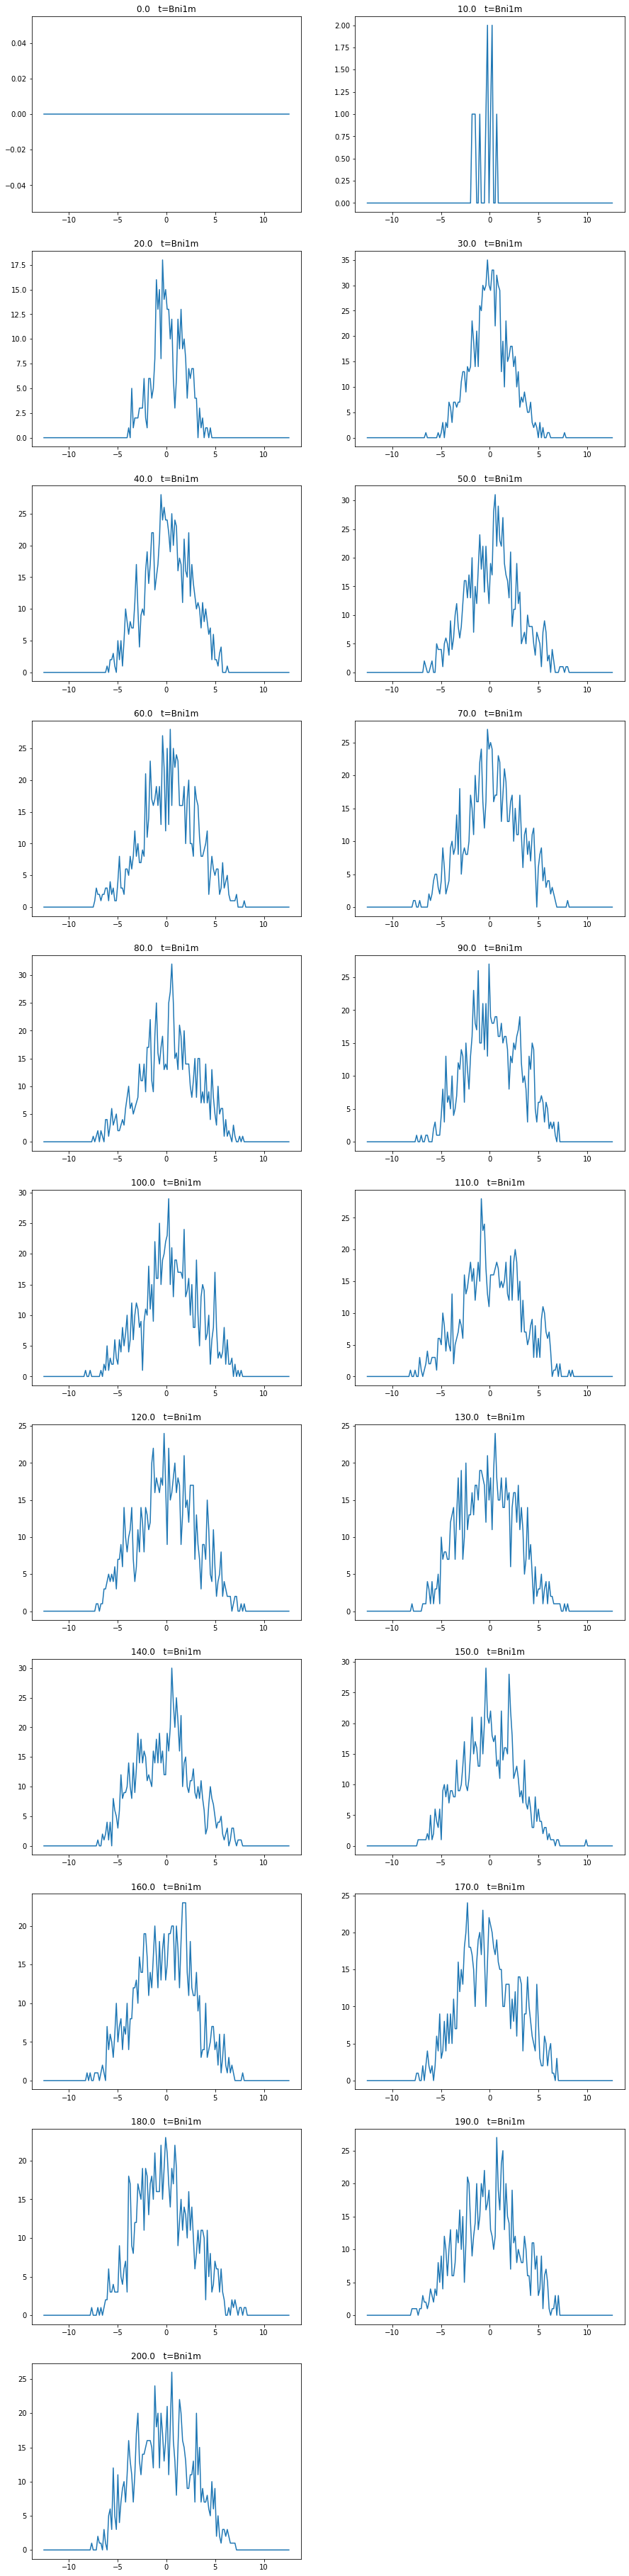

In [8]:
plot("Bni1m")

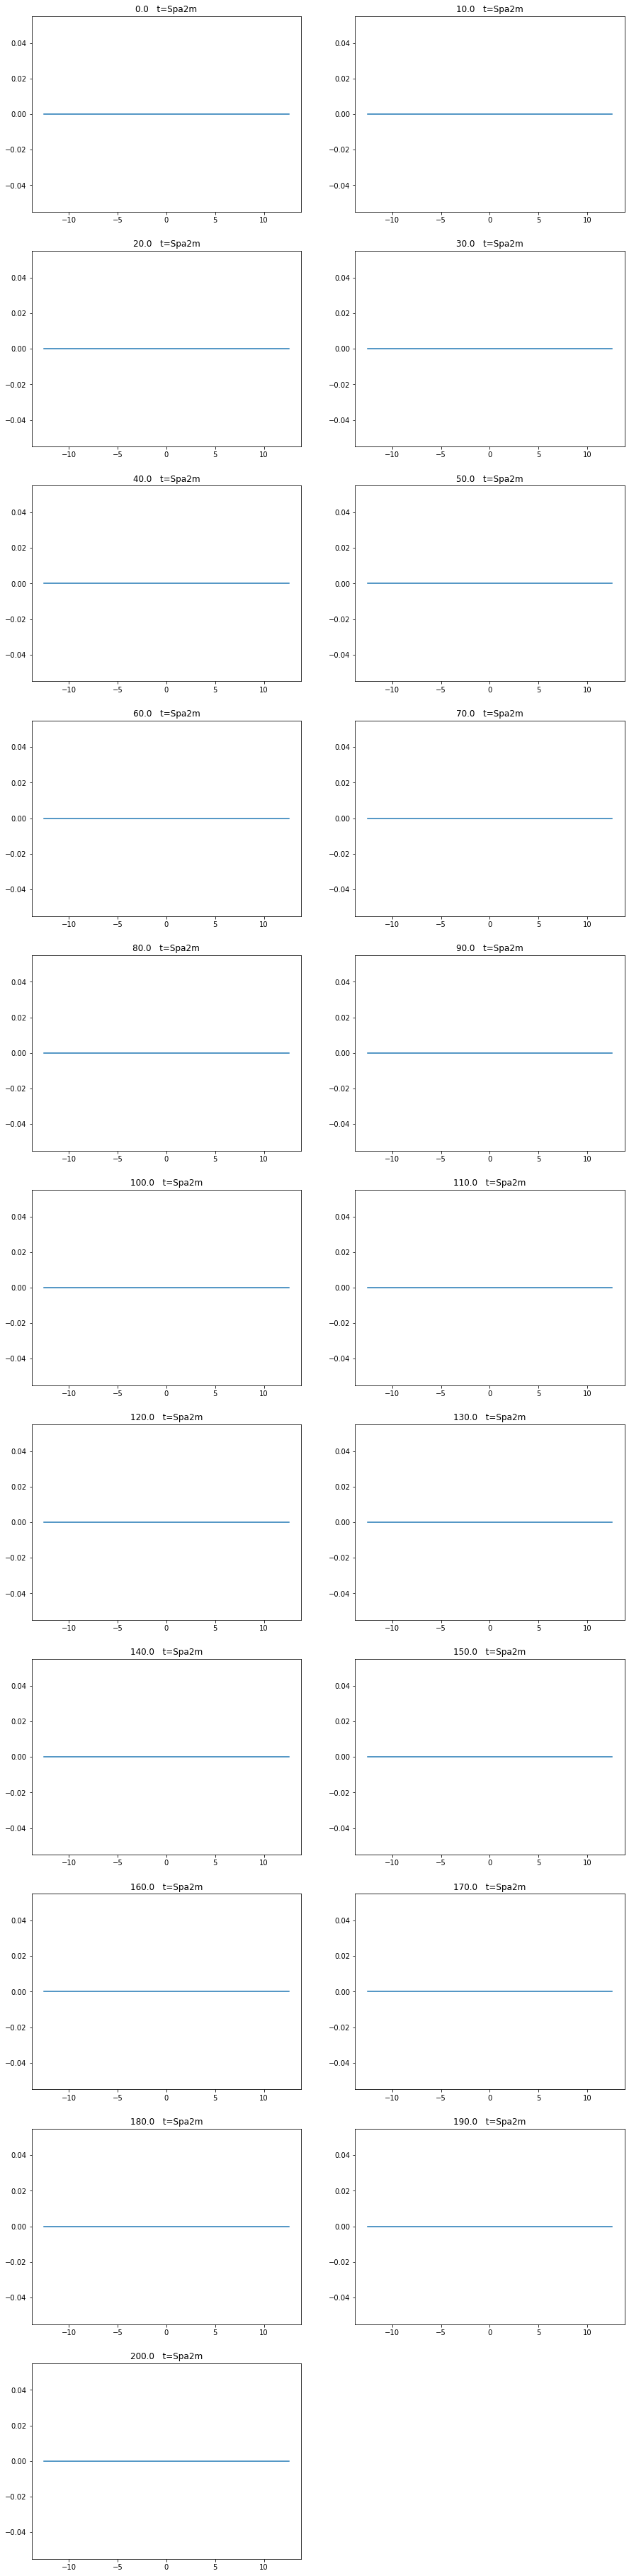

In [9]:
plot("Spa2m")

Text(0.5, 1.0, 'Input: Gradient of Cdc42')

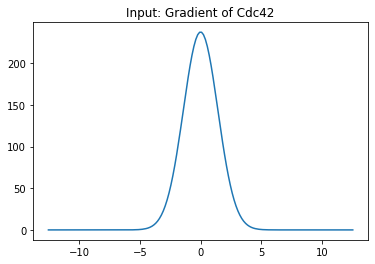

In [10]:
x_vals = model.domain.coordinates()[:, 0]
pg = Cdc42()
gradient = [pg.map([x]) for x in x_vals]
plt.plot(x_vals, gradient)
plt.title('Input: Gradient of Cdc42')